# Outcomes

The purpose of this section is to understand the effectiveness of our ADS by comparing its performance across sub-populations.  Here, we select one or more fairness or diversity measures (justifying our choice for the measure) and quatify the fairness of this ADS.

In addition, we will attempt to develop additional methods for analyzing ADS performance: think about stability, robustness, performance on difficult or otherwise important examples (in the style of LIME) or any other property that you believe is important to check for this ADS.

In [69]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as mtick
import seaborn as sns
import functools
import sklearn.metrics as skm
import fairlearn.metrics as fm
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

ads_output = pd.read_csv('../data/ADS_output.csv')

#Fix a typo in the dataset. (note that there are no null values in relevant_experience column)
ads_output = ads_output.rename(columns={"relevent_experience":"relevant_experience"})
ads_output['relevant_experience'] = ads_output['relevant_experience'].apply(lambda x: 
                        'Yes' if x=='Has relevent experience' else 'No')

display(ads_output.head())
print(ads_output.shape)

,enrollee_id,city,city_development_index,gender,relevant_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,prediction
0,31373,city_159,0.843,Female,Yes,No Enrollment,Masters,STEM,8,50-99,Pvt Ltd,1,246,0.0,0.0
1,28751,city_103,0.920,Not provided,No,Full time course,High School,Unknown,4,0,Unknown,3,75,0.0,1.0
2,2533,city_162,0.767,Male,Yes,Full time course,Graduate,STEM,4,500-999,Pvt Ltd,1,48,0.0,0.0
3,18712,city_103,0.920,Male,No,No Enrollment,Graduate,STEM,2,500-999,Public Sector,1,7,1.0,0.0
4,12900,city_138,0.836,Male,Yes,No Enrollment,Masters,STEM,20,100-500,Pvt Ltd,1,5,0.0,0.0


(5405, 15)


Given the context of our task, we consider the following metrics:
* Sample size
* Selection rate: the portion of predicted labels matching the ‘good’ outcome, which, in this case, is being a "job seeker". This is because companies will often provide extra benefit to those of their employees seeking new jobs in attempts to keep them. The job seekers will also receive more job oppertunities if other companies were to obtain this information.
* Accuracy: $\frac{TP + TN}{P + N}$
* FNR, percentage among job-seekers that were predicted to be non-seekers. This means those who could have gotten job oppertunities or higher chance of promotion did not get them: $\frac{FN}{FN + TP}$
* FPR, percentage among non-seekers that were predicted to be job-seeking. This means those who are not seeking new jobs receive potential promotion, which is a plus, and job oppertunities, which might or might not be an annoyance. The company, on the other hand, waste resources in trying to keep people who don't want to leave in the first place: $\frac{FP}{FP + TN}$
* Average Precision: Summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight
* ROC AUC score: Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.

## Gender

The first protected attribute we examine is gender, which is a categorical variable with values "Female", "Male", "Others", and "Not provided". As mentioned in previous section, there are disproportionally many men in the data.  

In [ ]:
#Get the prediction and the actual test results for comparison.
y_predict = ads_output['prediction']
y_test = ads_output['target']

In [31]:
def insensitive_roc_auc(y_true, y_score):
    #to handle subgroups with only one class.
    if sum(y_true)!=len(y_true) and sum(y_true)!=0:
        return skm.roc_auc_score(y_true, y_score)
    else:
        return np.nan

def samplesize(y_true, y_score):
    return len(y_true)

#Metrics 
metric_fns = {'samplesize': samplesize, 
              'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
              'FNR': false_negative_rate, 
              'FPR': false_positive_rate, 
              'accuracy': skm.accuracy_score,
              'average_precision': skm.average_precision_score,
              'roc_auc_score': insensitive_roc_auc 
              }

grouped_on_gender = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['gender'])

### Baseline Statistics

Let's first find the baseline statistics to compare to.

In [32]:
grouped_on_gender.overall

samplesize               5405
selection_rate       0.348566
FNR                  0.256569
FPR                  0.224276
accuracy             0.767993
average_precision    0.441032
roc_auc_score        0.759577
dtype: object

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020338445760>,
      dtype=object)

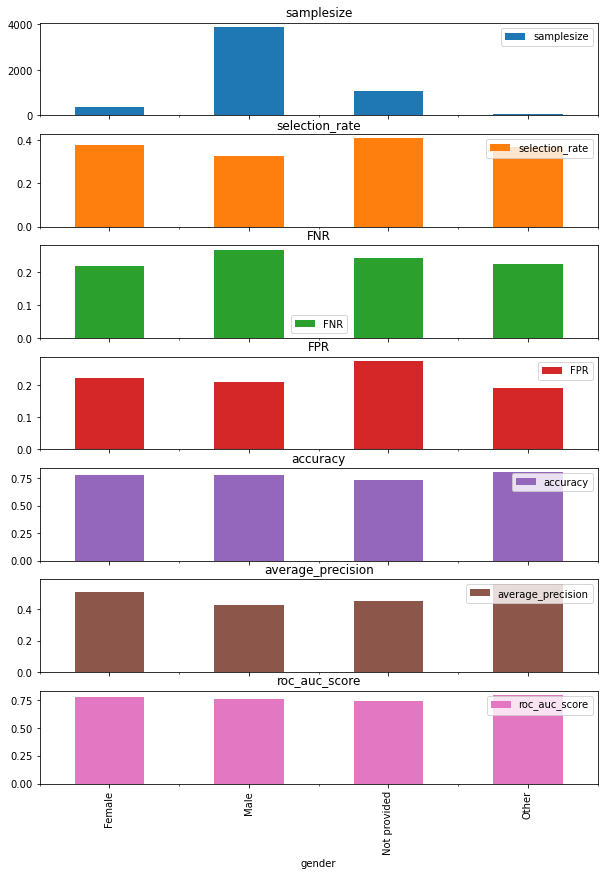

In [18]:
# Plot the metric values
grouped_on_gender.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Education Level
Next, we examine education level, which is correlated with socio-economic status. The categorical values consist of 'Primary School', 'High School', 'Graduate', 'Masters', and 'PhD'.

In [62]:
# set categorical order
education = pd.Categorical(ads_output['education_level'],
                                   categories=['Primary School', 'High School', 'Graduate', 'Masters', 'Phd'],
                                   ordered=True)
grouped_on_education = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=education)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002033C1FF310>,
      dtype=object)

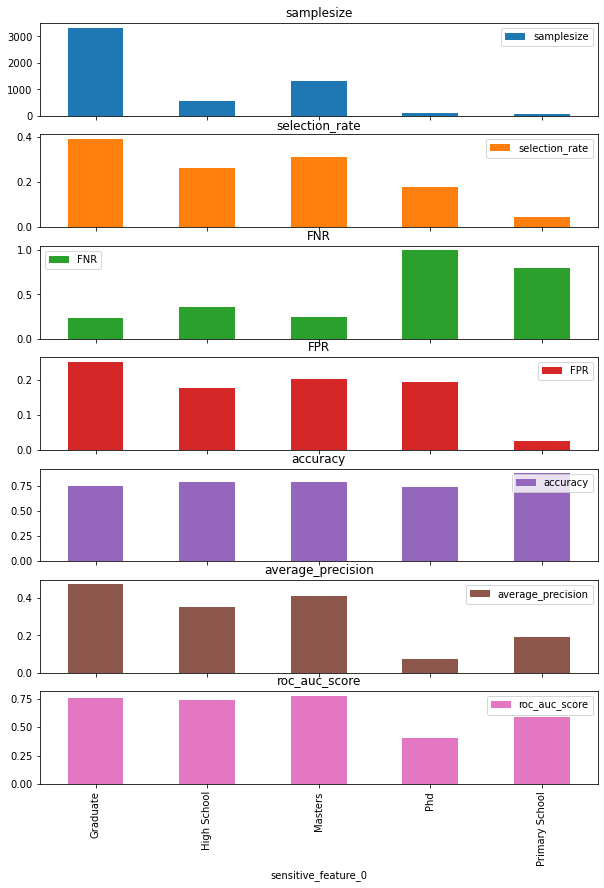

In [63]:
# Plot the metric values
grouped_on_education.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Relevant Experience
Next, we examine relevant experience, which is a binary variable containing either "yes" or "no".

In [51]:
grouped_on_rexperience = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['relevant_experience'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020338E895B0>,
      dtype=object)

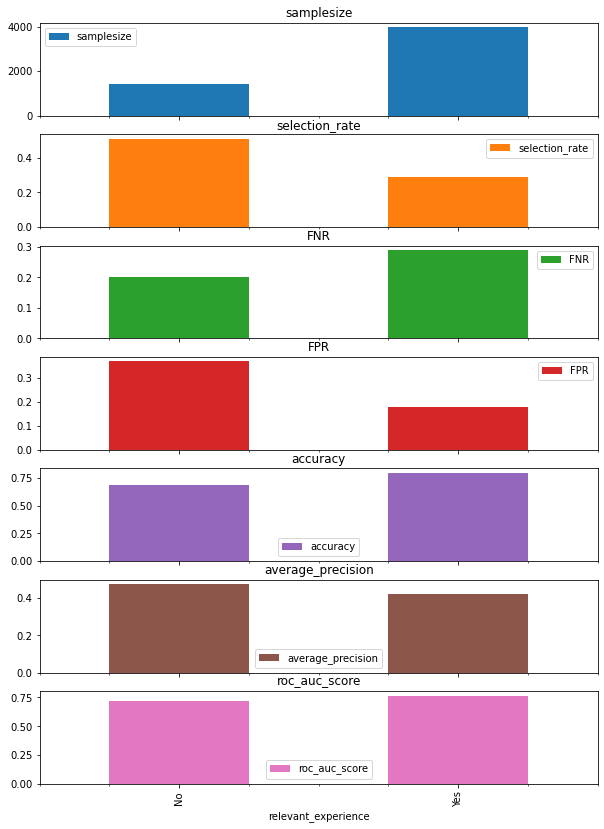

In [52]:
# Plot the metric values
grouped_on_rexperience.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Experience
Furthermore, we examine experience in general, which correlates with age. Recall that in previous section, we changed the years in experience of everyone with more than 20 years of experience to 20.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002033D16F160>,
      dtype=object)

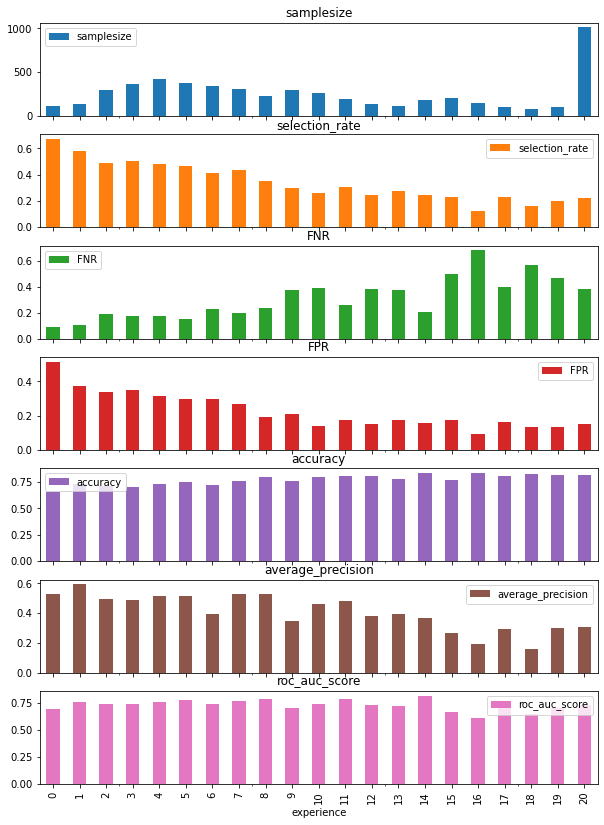

In [80]:
grouped_on_experience = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['experience'])
# Plot the metric values
grouped_on_experience.by_group.plot.bar(subplots=True, figsize=(10, 14))

## City Development
Lastly, we examine the development index of the city that the data scientist currently resides. The index is calculated base on five sub indices: infrastructure, waste, health, education and city product.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002033CFEF550>,
      dtype=object)

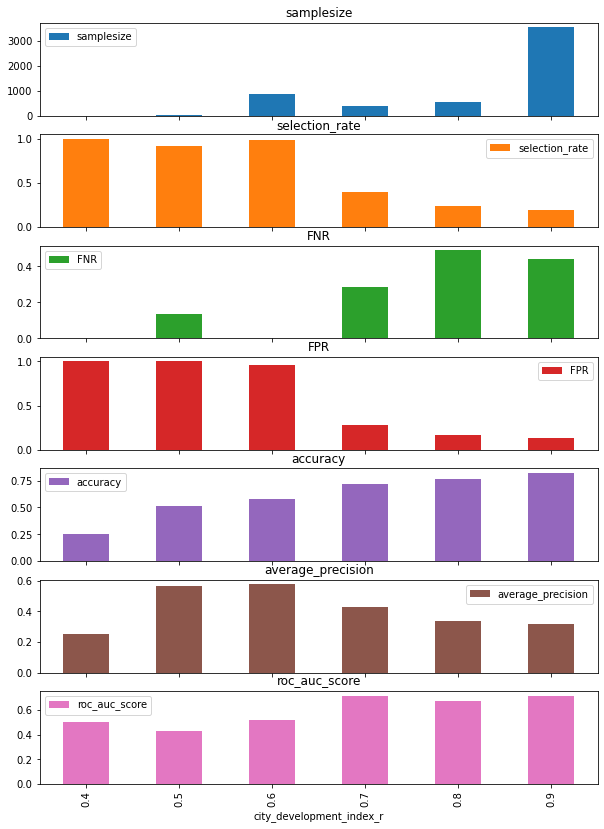

In [74]:
ads_output['city_development_index_r'] = ads_output['city_development_index'].apply(lambda x: round(x,1))

grouped_on_city_development = MetricFrame(metric_fns,
                             y_test, y_predict,
                             sensitive_features=ads_output['city_development_index_r'])

# Plot the metric values
grouped_on_city_development.by_group.plot.bar(subplots=True, figsize=(10, 14))

## Demographic Parity Ratio
The demographic parity ratio is defined as the ratio between the smallest and the largest group-level selection rate, across all values of the sensitive feature(s). The demographic parity ratio of 1 means that all groups have the same selection rate.

In [77]:
DPR_gender = fm.demographic_parity_ratio(y_test, y_predict,
                             sensitive_features=ads_output['gender'])
DPR_education = fm.demographic_parity_ratio(y_test, y_predict,
                             sensitive_features=ads_output['education_level'])
DPR_r_experience = fm.demographic_parity_ratio(y_test, y_predict,
                             sensitive_features=ads_output['relevant_experience'])
DPR_experience = fm.demographic_parity_ratio(y_test, y_predict,
                             sensitive_features=ads_output['experience'])
DPR_city = fm.demographic_parity_ratio(y_test, y_predict,
                             sensitive_features=ads_output['city_development_index_r'])

print('The DPR for gender is', DPR_gender)
print('The DPR for education level is', DPR_education)
print('The DPR for relevant experience is', DPR_r_experience)
print('The DPR for experience is', DPR_experience)
print('The DPR for city development is', DPR_city)

The DPR for gender is 0.8044478625756135
The DPR for education level is 0.11882350847849682
The DPR for relevant experience is 0.5673968038586622
The DPR for experience is 0.18074324324324326
The DPR for city development is 0.19492242595204515


## Equalized Odds Ratio
Equalized Odds Ratio is the smaller of two metrics: true_positive_rate_ratio and false_positive_rate_ratio. The equalized odds ratio of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates.

In [79]:
EOR_gender = fm.equalized_odds_ratio(y_test, y_predict,
                             sensitive_features=ads_output['gender'])
EOR_education = fm.equalized_odds_ratio(y_test, y_predict,
                             sensitive_features=ads_output['education_level'])
EOR_r_experience = fm.equalized_odds_ratio(y_test, y_predict,
                             sensitive_features=ads_output['relevant_experience'])
EOR_experience = fm.equalized_odds_ratio(y_test, y_predict,
                             sensitive_features=ads_output['experience'])
EOR_city = fm.equalized_odds_ratio(y_test, y_predict,
                             sensitive_features=ads_output['city_development_index_r'])

print('The EOR for gender is', EOR_gender)
print('The EOR for education level is', EOR_education)
print('The EOR for relevant experience is', EOR_r_experience)
print('The EOR for experience is', EOR_experience)
print('The EOR for city development is', EOR_city)

The EOR for gender is 0.6913580246913581
The EOR for education level is 0.0
The EOR for relevant experience is 0.48455158002473453
The EOR for experience is 0.18040873854827344
The EOR for city development is 0.1284617951284618
